# Pseudopotentials

In this example, we'll look at how to use various pseudopotential (PSP)
formats in DFTK and discuss briefly the utility and importance of
pseudopotentials.

Currently, DFTK supports norm-conserving (NC) PSPs in
separable (Kleinman-Bylander) form. Two file formats can currently
be read and used: analytical Goedecker-Teter-Hutter (GTH) PSPs
and numeric Unified Pseudopotential Format (UPF) PSPs.

In brief, the pseudopotential approach replaces the all-electron
atomic potential with an effective atomic potential. In this pseudopotential,
tightly-bound core electrons are completely eliminated ("frozen") and
chemically-active valence electron wavefunctions are replaced with
smooth pseudo-wavefunctions whose Fourier representations decay quickly.
Both these transformations aim at reducing the number of Fourier modes required
to accurately represent the wavefunction of the system, greatly increasing
computational efficiency.

Different PSP generation codes produce various file formats which contain the
same general quantities required for pesudopotential evaluation. GTH PSPs
are constructed from a fixed functional form based on Gaussians, and the files
simply tablulate various coefficients fitted for a given element. UPF PSPs
take a more flexible approach where the functional form used to generate the
PSP is arbitrary, and the resulting functions are tabulated on a radial grid
in the file. The UPF file format is documented
[on the Quantum Espresso Website](http://pseudopotentials.quantum-espresso.org/home/unified-pseudopotential-format).

In this example, we will compare the convergence of an analytical GTH PSP with
a modern numeric norm-conserving PSP in UPF format from
[PseudoDojo](http://www.pseudo-dojo.org/).
Then, we will compare the bandstructure at the converged parameters calculated
using the two PSPs.

In [1]:
using AtomsBuilder
using DFTK
using Unitful
using UnitfulAtomic
using PseudoPotentialData
using Plots

Here, we will use a Perdew-Wang LDA PSP
from [PseudoDojo](http://www.pseudo-dojo.org/),
which is available via the
[JuliaMolSim PseudoPotentialData](https://github.com/JuliaMolSim/PseudoPotentialData.jl)
package. See [the documentation of PseudoPotentialData](https://juliamolsim.github.io/PseudoPotentialData.jl/stable/)
for the list of available pseudopotential families.

In [2]:
family_upf = PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf");

Such a `PseudoFamily` object acts like a dictionary from an element symbol
to a pseudopotential file. They can be directly employed to select the
appropriate pseudopotential when constructing an `ElementPsp`
or a model based on an `AtomsBase`-compatible system. For the latter
see the `run_bands` function below for an example.

An alternative to a `PseudoFamily` object is in all cases a plain
`Dict` to map from atomic symbols to the employed pseudopotential file.
For demonstration purposes we employ this
in combination with the GTH-type pseudopotentials:

In [3]:
family_gth = PseudoFamily("cp2k.nc.sr.lda.v0_1.semicore.gth")
pseudopotentials_gth = Dict(:Si => family_gth[:Si])

Dict{Symbol, String} with 1 entry:
  :Si => "/home/runner/.julia/artifacts/966fd9cdcd7dbaba6dc2bf43ee50dd81e63e883…

First, we'll take a look at the energy cutoff convergence of these two pseudopotentials.
For both pseudos, a reference energy is calculated with a cutoff of 140 Hartree, and
SCF calculations are run at increasing cutoffs until 1 meV / atom convergence is reached.

<img src="https://docs.dftk.org/stable/assets/si_pseudos_ecut_convergence.png" width=600 height=400 />

The converged cutoffs are 26 Ha and 18 Ha for the GTH
and UPF pseudos respectively. We see that the GTH pseudopotential
is much *harder*, i.e. it requires a higher energy cutoff, than the UPF PSP. In general,
numeric pseudopotentials tend to be softer than analytical pseudos because of the
flexibility of sampling arbitrary functions on a grid.

For some pseudopotentials the `PseudoFamily` contains hints for the recommended
cutoffs as metadata. For most PseudoDojo potentials this is indeed the case:

In [4]:
recommended_cutoff(family_upf, :Si)

(Ecut = 16.0, supersampling = 2.0, Ecut_density = 64.0)

We see the recommended value is very close to what we determined above.
Sometimes more detailed information is also available by looking at the raw
metadata associated to this combination of pseudopotential family and element:

In [5]:
pseudometa(family_upf, :Si)

Dict{String, Any} with 6 entries:
  "rcut"           => 10.0
  "Ecut"           => 16
  "supersampling"  => 2.0
  "cutoffs_normal" => Dict{String, Any}("Ecut"=>16, "supersampling"=>2.0)
  "cutoffs_high"   => Dict{String, Any}("Ecut"=>22, "supersampling"=>2.0)
  "cutoffs_low"    => Dict{String, Any}("Ecut"=>12, "supersampling"=>2.0)

Here, we see that multiple recommended cutoffs are made available in the metadata.
Note, that `recommended_cutoff` can also be directly executed on a `Model`
or an `ElementPsp`, e.g.

In [6]:
Si = ElementPsp(:Si, family_upf)
recommended_cutoff(Si)

(Ecut = 16.0, supersampling = 2.0, Ecut_density = 64.0)

In [7]:
pseudometa(Si)

Dict{String, Any} with 6 entries:
  "rcut"           => 10.0
  "Ecut"           => 16
  "supersampling"  => 2.0
  "cutoffs_normal" => Dict{String, Any}("Ecut"=>16, "supersampling"=>2.0)
  "cutoffs_high"   => Dict{String, Any}("Ecut"=>22, "supersampling"=>2.0)
  "cutoffs_low"    => Dict{String, Any}("Ecut"=>12, "supersampling"=>2.0)

Next, to see that the different pseudopotentials give reasonably similar results,
we'll look at the bandstructures calculated using the GTH and UPF PSPs. Even though
the converged cutoffs are higher, we perform these calculations with a cutoff of
12 Ha for both PSPs.

In [8]:
function run_bands(pseudopotentials)
    system = bulk(:Si; a=10.26u"bohr")

    # These are (as you saw above) completely unconverged parameters
    model = model_DFT(system; functionals=LDA(), temperature=1e-2, pseudopotentials)
    basis = PlaneWaveBasis(model; Ecut=12, kgrid=(4, 4, 4))

    scfres   = self_consistent_field(basis; tol=1e-4)
    bandplot = plot_bandstructure(compute_bands(scfres))
    (; scfres, bandplot)
end;

The SCF and bandstructure calculations can then be performed using the two PSPs,
where we notice in particular the difference in total energies.

In [9]:
result_gth = run_bands(pseudopotentials_gth)
result_gth.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.921027068904                   -0.69    5.5    276ms
  2   -7.925585419758       -2.34       -1.24    2.9    239ms
  3   -7.926170967171       -3.23       -2.41    2.8    210ms
  4   -7.926189187476       -4.74       -3.01    3.2    456ms
  5   -7.926189846385       -6.18       -3.96    2.4    172ms
  6   -7.926189862290       -7.80       -4.69    3.5    194ms


Energy breakdown (in Ha):
    Kinetic             3.1590005 
    AtomicLocal         -2.1424271
    AtomicNonlocal      1.6042930 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5515502 
    Xc                  -2.4000864
    Entropy             -0.0031626

    total               -7.926189862290

In [10]:
result_upf = run_bands(family_upf)
result_upf.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.515511951137                   -0.93    5.6    207ms
  2   -8.518488489196       -2.53       -1.46    3.1    173ms
  3   -8.518839557758       -3.45       -2.80    2.9    236ms
  4   -8.518855368331       -4.80       -3.17    4.4    525ms
  5   -8.518855487850       -6.92       -3.47    2.1    173ms
  6   -8.518855546407       -7.23       -4.62    1.5    161ms


Energy breakdown (in Ha):
    Kinetic             3.0954159 
    AtomicLocal         -2.3650740
    AtomicNonlocal      1.3082450 
    Ewald               -8.4004648
    PspCorrection       0.3952264 
    Hartree             0.5521778 
    Xc                  -3.1011624
    Entropy             -0.0032195

    total               -8.518855546407

But while total energies are not physical and thus allowed to differ,
the bands (as an example for a physical quantity) are very similar for both pseudos:

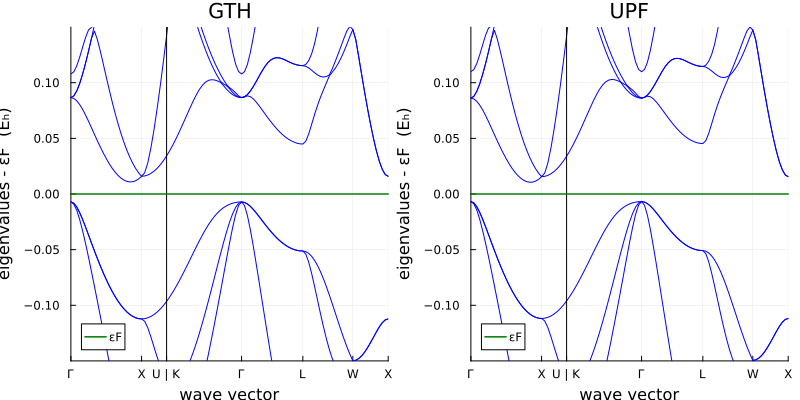

In [11]:
plot(result_gth.bandplot, result_upf.bandplot, titles=["GTH" "UPF"], size=(800, 400))